# Inverse Kinematics of a 2R Planar Manipulator
## Newton's Method: Pure vs Damped (Line Search)

In this notebook we illustrate how the classical Newton method can fail to converge in some cases of inverse kinematics, and how a damped Newton method with Armijo backtracking line search can fix these issues.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve, LinAlgError
from dataclasses import dataclass

%matplotlib inline

##  Utility Functions

We define functions for:
- **forward_xy**: forward kinematics,
- **residual**: nonlinear system $F(\theta) = 0$,
- **jacobian**: Jacobian $\partial F/\partial \theta$,
- **reachable**: workspace reachability condition,
- **normalize_angles**: keep angles within $(- \pi, \pi]$.
  

## 1. Forward Kinematics and Jacobian

In [ ]:
def forward_xy(theta, L1, L2):
    # Extrae los dos ángulos articulares del vector theta
    # y los convierte explícitamente a flotantes para evitar problemas de tipo.
    t1, t2 = map(float, theta)

    # Ecuaciones de la cinemática directa para un manipulador plano de 2 eslabones:
    # Se suma el aporte del primer eslabón (L1) y del segundo (L2).
    x = L1*np.cos(t1) + L2*np.cos(t1 + t2)
    y = L1*np.sin(t1) + L2*np.sin(t1 + t2)

    # Devuelve un vector numpy con la posición cartesiana [x, y].
    return np.array([x, y], dtype=float)


def residual(theta, L1, L2, xd, yd):
    # Calcula el error entre la posición actual del efector final
    # y la posición deseada (xd, yd).
    # forward_xy(theta, L1, L2) → posición actual
    # np.array([xd, yd]) → posición deseada
    return forward_xy(theta, L1, L2) - np.array([xd, yd], dtype=float)


def jacobian(theta, L1, L2):
    # Extrae ángulos y los convierte en floats
    t1, t2 = map(float, theta)

    # Calcula senos y cosenos necesarios:
    # - s1, c1 corresponden a theta1
    # - s12, c12 corresponden a (theta1 + theta2)
    s1, c1 = np.sin(t1), np.cos(t1)
    s12, c12 = np.sin(t1 + t2), np.cos(t1 + t2)

    # Construye la matriz Jacobiana J(θ), que relaciona
    # cambios en los ángulos articulares con cambios en (x, y).
    # Cada fila corresponde a derivadas parciales respecto a θ1 y θ2.
    return np.array([[-L1*s1 - L2*s12, -L2*s12],
                     [ L1*c1 + L2*c12,  L2*c12]], dtype=float)


def normalize_angles(theta):
    # Convierte el vector theta a un array numpy de floats
    th = np.array(theta, dtype=float)

    # Normaliza cada ángulo al intervalo (-pi, pi].
    # La operación funciona así:
    # 1) Se le suma π al ángulo.
    # 2) Se aplica el módulo 2π → restringe el valor a [0, 2π).
    # 3) Se resta π → el resultado cae en (-π, π].
    return (th + np.pi) % (2*np.pi) - np.pi


## 2. Newton Method Implementation (Pure and Damped)

We now implement the inverse kinematics solver using **Newton’s method**.  
The solver can run in two modes:

- **Pure Newton** (`damping=False`): always takes the full Newton step.  
- **Damped Newton** (`damping=True`): uses Armijo backtracking line search to ensure sufficient decrease of the merit function  

\begin{equation*}
\phi(\theta) = \tfrac{1}{2}\|F(\theta)\|^2,
\end{equation*}

where $F(\theta)$ is the residual vector.

---

### Newton Step

At iteration $k$, we solve the linear system:

\begin{equation*}
J(\theta_k) \, s_k = -F(\theta_k),
\end{equation*}

where:
- $F(\theta_k) \in \mathbb{R}^2$ is the residual,
- $J(\theta_k) \in \mathbb{R}^{2\times 2}$ is the Jacobian,
- $s_k$ is the Newton direction.

---

### Pure Newton Update

Without damping, the update is simply:

\begin{equation*}
\theta_{k+1} = \theta_k + s_k,
\end{equation*}

i.e. we take the **full step** in the Newton direction.

---

### Damped Newton Update (Line Search)

With damping, we introduce a **step length parameter** $\alpha_k \in (0,1]$:

\begin{equation*}
\theta_{k+1} = \theta_k + \alpha_k s_k.
\end{equation*}

The value of $\alpha_k$ is chosen by **Armijo backtracking**:

1. Start with $\alpha_k = 1$.
2. While the sufficient decrease condition fails:

\begin{equation*}
\phi(\theta_k + \alpha_k s_k) > (1 - c_1 \alpha_k)\,\phi(\theta_k),
\end{equation*}

   reduce the step length:

\begin{equation*}
\alpha_k \leftarrow \tfrac{1}{2}\alpha_k.
\end{equation*}

Here:
- $\phi(\theta)$ is the merit function,
- $c_1 \in (0,1)$ is a constant (typical values: $10^{-4}$ to $10^{-2}$).

If $\alpha_k$ becomes smaller than a minimum threshold (`alpha_min`), the search stops.

---

### Components in Code

- **`NewtonResult`**: dataclass to store the result of the algorithm  
  - `theta`: final joint angles  
  - `f_norm`: infinity-norm of the residual  
  - `iters`: number of iterations performed  
  - `converged`: boolean flag  
  - `history`: list of dictionaries with iteration details (`f_inf`, `alpha`, `step_norm`, etc.)  
  - `stop_reason`: why the algorithm stopped (`residual`, `step`, or `max_iter`).

- **`newton_ik`**: main solver  
  - Inputs: link lengths `L1, L2`, target `(xd, yd)`, initial guess `theta0`, tolerances.  
  - Optional damping parameters:  
    - `c1`: Armijo constant,  
    - `alpha_min`: minimum step length allowed.  
  - Returns: a `NewtonResult` object with full diagnostic information.

---

### Key Difference

- **Pure Newton**: fastest locally (quadratic convergence near the root), but fragile globally.  
- **Damped Newton**: slower in some cases, but guarantees **global convergence** to a solution from a much wider set of initial guesses.


### 2.1 Algorithm Flowchart: Pure vs Damped Newton

The following diagram summarizes the iteration process:

```text
                ┌───────────────────────┐
                │   Initial guess θ₀    │
                └───────────┬───────────┘
                            │
                            ▼
                  ┌─────────────────────┐
                  │ Compute residual F  │
                  │    and Jacobian J   │
                  └───────────┬─────────┘
                              │
                              ▼
                 ┌─────────────────────────┐
                 │ Solve Newton step: Js=-F │
                 └───────────┬─────────────┘
                              │
          ┌───────────────────┴─────────────────────┐
          │                                         │
          ▼                                         ▼
 ┌───────────────────┐                     ┌───────────────────────────┐
 │ Damping = False   │                     │ Damping = True            │
 │ (Pure Newton)     │                     │ (Armijo Backtracking)     │
 │ α ← 1             │                     │ α ← 1                     │
 └─────────┬─────────┘                     └─────────┬─────────────────┘
           │                                         │
           ▼                                         ▼
   ┌────────────────────┐                  ┌──────────────────────────────┐
   │ θ_new = θ + α·s    │    If φ(θ+αs) >  │  Reduce α ← α/2 until        │
   └─────────┬──────────┘    (1-c₁α)φ(θ): │  φ(θ+αs) ≤ (1-c₁α)φ(θ)        │
             │                            └──────────────────────────────┘
             ▼                                         │
   ┌────────────────────────┐                         │
   │ Check convergence:      │<───────────────────────┘
   │  ‖F‖∞ ≤ tol_f           │
   │  or ‖θ_new-θ‖∞ ≤ tol_x  │
   └─────────┬───────────────┘
             │
             ▼
   ┌────────────────────┐
   │   Stop / Return    │
   └────────────────────┘


In [25]:
@dataclass
class NewtonResult:
    # Esta clase de datos se usa como contenedor de resultados
    # tras ejecutar el método de Newton.
    theta: np.ndarray   # Ángulos finales calculados [θ1, θ2].
    f_norm: float       # Norma del residuo en la solución encontrada.
    iters: int          # Número de iteraciones realizadas.
    converged: bool     # Bandera booleana que indica si se logró convergencia.
    history: list       # Lista con información detallada de cada iteración.
    stop_reason: str    # Razón por la que se detuvo el algoritmo
                        # ("residual", "step", "max_iter").
def newton_ik(L1, L2, xd, yd, theta0,
              tol_f=1e-10, tol_x=1e-12, kmax=50,
              damping=False, c1=1e-2, alpha_min=1e-8,
              clamp_angles=True):
    # Implementa el método de Newton (con o sin damping)
    # para resolver la cinemática inversa de un manipulador 2R.

    # ---------------------------------------------
    # Inicialización
    # ---------------------------------------------
    th = np.array(theta0, dtype=float)  # Convierte la semilla inicial en array float
    hist = []                           # Lista para guardar el historial de iteraciones

    # Función de mérito: φ(θ) = 1/2 ||F(θ)||^2
    def phi(z):
        Fz = residual(z, L1, L2, xd, yd)   # Calcula residuo en z
        return 0.5*float(Fz @ Fz)          # Producto interno F·F = ||F||^2
    # ---------------------------------------------
    # Iteraciones de Newton
    # ---------------------------------------------
    for k in range(kmax):
        # Calcula el residuo en la iteración actual
        F = residual(th, L1, L2, xd, yd)
        # Norma infinito del residuo (criterio de parada)
        f_inf = norm(F, ord=np.inf)

        # Calcula el Jacobiano en la configuración actual
        J = jacobian(th, L1, L2)

        # Resuelve el sistema lineal J·s = -F para obtener el paso de Newton s
        try:
            s = solve(J, -F)
        except LinAlgError:
            # Si el Jacobiano es singular o mal condicionado,
            # se le añade una pequeña identidad para estabilizar.
            s = solve(J + 1e-10*np.eye(2), -F)
        # ---------------------------------------------
        # Selección del tamaño de paso α (damping)
        # ---------------------------------------------
        alpha = 1.0  # Por defecto, paso completo (Newton puro)
        if damping:
            phi0 = phi(th)  # φ en el punto actual
            # Búsqueda en línea tipo Armijo:
            # Reducir α mientras no se cumpla la condición de descenso suficiente
            while alpha > alpha_min and phi(th + alpha*s) > (1 - c1*alpha)*phi0:
                alpha *= 0.5
        # ---------------------------------------------
        # Actualización de la solución
        # ---------------------------------------------
        th_new = th + alpha*s
        if clamp_angles:
            # Normaliza los ángulos al intervalo (-π, π]
            th_new = normalize_angles(th_new)

        # Guarda en el historial los datos de esta iteración
        hist.append({
            "k": k,               # Número de iteración
            "theta": th.copy(),   # Ángulo actual
            "f_inf": f_inf,       # Norma infinito del residuo
            "alpha": alpha,       # Tamaño de paso usado
            "step_norm": norm(s)  # Norma del vector de paso s
        })
        # ---------------------------------------------
        # Criterios de parada
        # ---------------------------------------------
        if f_inf <= tol_f:
            # Residuo suficientemente pequeño → convergencia
            return NewtonResult(th, f_inf, k, True, hist, "residual")

        if norm(th_new - th, ord=np.inf) <= tol_x:
            # Cambio en la solución demasiado pequeño → detener
            th = th_new
            F = residual(th, L1, L2, xd, yd)
            return NewtonResult(th, norm(F, ord=np.inf), k+1, True, hist, "step")

        # Avanzar a la siguiente iteración
        th = th_new
    # ---------------------------------------------
    # Si se agotó el número máximo de iteraciones
    # ---------------------------------------------
    F = residual(th, L1, L2, xd, yd)
    return NewtonResult(th, norm(F, ord=np.inf), kmax, False, hist, "max_iter")


## 3. Test Harness: Comparing Pure vs Damped Newton

The function `run_case` is a **diagnostic tool** to compare the performance of 
**pure Newton** (`damping=False`) versus **damped Newton** (`damping=True`) 
for the same inverse kinematics problem.

### Function behavior
- **Inputs:**  
  - `L1, L2`: link lengths of the 2R manipulator.  
  - `(xd, yd)`: desired target position in Cartesian space.  
  - `theta0`: initial guess for the joint angles.  
  - Optional: tolerances `tol_f`, `kmax` (maximum iterations).  

- **Outputs (printed to console):**  
  - Whether each method converged or not.  
  - Number of iterations used.  
  - Final residual norm.  
  - Stop reason (`residual`, `step`, or `max_iter`).  
  - Minimum step length `alpha` chosen during line search.  

### Additional details
- An **inner helper** `summarize()` is used to format and print results for each method.  
- After reporting convergence data, the function also prints the **evolution of the merit function**  

\begin{equation*}
\phi(\theta) = \tfrac{1}{2}\,\|F(\theta)\|^2,
\end{equation*}

for the first few iterations, so that we can compare how 
Newton’s method behaves with and without damping.  

### Purpose
This function provides a **side-by-side comparison** of robustness and efficiency:
- **Pure Newton** converges quickly when it works, but may fail for poor initial guesses.  
- **Damped Newton** uses backtracking to enforce sufficient decrease in $\phi(\theta)$, 
leading to more reliable convergence, especially near singularities or ill-conditioned cases.


In [ ]:
def run_case(L1, L2, xd, yd, theta0, kmax=50, tol_f=1e-10):
    # Esta función compara el desempeño de Newton puro y Newton con damping
    # para un mismo caso de cinemática inversa (L1, L2, target (xd, yd), semilla inicial theta0).

    # ---------------------------------------------
    # Imprime encabezado del caso
    # ---------------------------------------------
    # Muestra en pantalla el target y la semilla inicial formateados.
    print(f"\n=== Case: target=({xd:.3f},{yd:.3f}), theta0={np.array(theta0)} ===")

    # ---------------------------------------------
    # Ejecuta Newton Puro (damping=False)
    # ---------------------------------------------
    res_pure = newton_ik(L1, L2, xd, yd, theta0,
                         kmax=kmax, tol_f=tol_f, damping=False)

    # ---------------------------------------------
    # Ejecuta Newton con Damping (damping=True)
    # ---------------------------------------------
    # Usa c1=1e-2 como constante de Armijo.
    res_damped = newton_ik(L1, L2, xd, yd, theta0,
                           kmax=kmax, tol_f=tol_f, damping=True, c1=1e-2)

    # ---------------------------------------------
    # Función auxiliar para imprimir resultados
    # ---------------------------------------------
    def summarize(tag, R):
        # Extrae los valores de alpha usados en todas las iteraciones
        alphas = [h["alpha"] for h in R.history]
        # Si hubo convergencia, reporta el número de iteraciones, si no, None
        took = R.iters if R.converged else None
        # Construye un mensaje resumido con:
        # - método ("PURE" o "DAMP")
        # - si convergió o no
        # - número de iteraciones
        # - norma final del residuo
        # - razón de parada
        # - mínimo valor de alpha que se usó
        msg = (f"{tag:>7} | converged={R.converged:5} | iters={took} | "
               f"f_norm={R.f_norm:.2e} | stop={R.stop_reason} | "
               f"min(alpha)={np.min(alphas):.3e}")
        print(msg)

    # Imprime resumen de Newton puro
    summarize("PURE", res_pure)
    # Imprime resumen de Newton con damping
    summarize("DAMP", res_damped)

    # ---------------------------------------------
    # Imprime evolución de la función de mérito φ
    # en las primeras iteraciones
    # ---------------------------------------------
    for name, R in [("PURE", res_pure), ("DAMP", res_damped)]:
        phis = []
        # Recorre el historial de iteraciones y calcula φ(θ)=0.5*F·F
        for h in R.history:
            phis.append(0.5*np.dot(residual(h["theta"], L1, L2, xd, yd),
                                   residual(h["theta"], L1, L2, xd, yd)))
        # Muestra las primeras 5-6 evaluaciones de φ para comparar
        print(f"{name} phi[0..min(5,len))]:", [f"{v:.2e}" for v in phis[:6]])


## 4. Experiments: Problematic Cases

In [26]:
L1, L2 = 1.0, 0.8

tests = [
    # --- Workspace boundary (exterior) ---
    {"target": (1.799, 0.000), "theta0": [0.8, 0.8]},       # casi en el alcance máximo
    {"target": (1.799, 0.005), "theta0": [2.4, -0.2]},      # borde, semilla lejana

    # --- Near singularities (links almost aligned) ---
    {"target": (1.70, 0.10), "theta0": [np.pi-1e-3, -1e-3]}, # θ2 ≈ 0, casi alineados
    {"target": (1.70, 0.10), "theta0": [-np.pi+1e-3, 1e-3]}, # otra rama cerca singularidad

    # --- Close to origin (interior boundary) ---
    {"target": (0.201, 0.000), "theta0": [2.9, -2.8]},      # muy cerca del límite interior
    {"target": (0.200, 0.005), "theta0": [-1.7, 1.6]},      # casi mínimo alcance

    # --- Interior point but misleading seeds ---
    {"target": (1.10, 0.60), "theta0": [2.9, -2.8]},        # dentro del workspace, semilla en rama equivocada
]

for t in tests:
    xd, yd = t["target"]
    run_case(L1, L2, xd, yd, t["theta0"])



=== Case: target=(1.799,0.000), theta0=[0.8 0.8] ===
   PURE | converged=    0 | iters=None | f_norm=1.99e+00 | stop=max_iter | min(alpha)=1.000e+00
   DAMP | converged=    1 | iters=11 | f_norm=6.44e-15 | stop=residual | min(alpha)=5.000e-01
PURE phi[0..min(5,len))]: ['1.78e+00', '2.07e+00', '2.74e+00', '2.75e+00', '2.71e+00', '2.71e+00']
DAMP phi[0..min(5,len))]: ['1.78e+00', '6.92e-01', '5.54e-01', '7.63e-02', '5.80e-03', '2.43e-04']

=== Case: target=(1.799,0.005), theta0=[ 2.4 -0.2] ===
   PURE | converged=    1 | iters=20 | f_norm=4.44e-16 | stop=residual | min(alpha)=1.000e+00
   DAMP | converged=    1 | iters=14 | f_norm=5.88e-13 | stop=residual | min(alpha)=6.250e-02
PURE phi[0..min(5,len))]: ['5.39e+00', '2.68e+00', '4.83e+00', '1.88e+00', '3.00e+00', '5.68e+00']
DAMP phi[0..min(5,len))]: ['5.39e+00', '2.68e+00', '1.82e+00', '1.26e+00', '1.11e+00', '4.46e-01']

=== Case: target=(1.700,0.100), theta0=[ 3.14059265e+00 -1.00000000e-03] ===
   PURE | converged=    0 | iters=None

## 5. Analysis of Problematic Cases

The experiments highlight three different behaviors:

1. **Cases where pure Newton fails but damped Newton converges**  
   - Near the workspace boundary, near singularities, or close to the base (high sensitivity).  
   - Damped Newton rescues the iteration by reducing the step size $\alpha_k$.

2. **Cases where both converge, but damping improves stability or efficiency**  
   - Pure Newton converges, but with oscillations or requiring more iterations.  
   - Damping smooths the decrease of the merit function $\phi(\theta)$ and often reduces the iteration count.

3. **Cases where both methods converge equally well**  
   - For interior targets with reasonable seeds, both behave identically ($\alpha_k = 1$ always).

---

### Comparative Results

| Target (xd, yd) | Initial guess $\theta_0$ | Pure Newton | Damped Newton | Notes |
|-----------------|--------------------------|-------------|---------------|-------|
| (1.799, 0.000)  | [0.8, 0.8]               | ❌ fail (max_iter) | ✅ converged in 11 iters | Boundary case, ill-conditioned Jacobian |
| (1.799, 0.005)  | [2.4, -0.2]              | ✅ converged in 20 iters | ✅ converged in 14 iters | Both succeed, damping is faster |
| (1.700, 0.100)  | [π, -0.001]              | ❌ fail (max_iter) | ✅ converged in 11 iters | Near singularity ($\theta_2 \approx 0$) |
| (1.700, 0.100)  | [-π, 0.001]              | ✅ converged in 9 iters | ✅ converged in 12 iters | Both succeed, similar performance |
| (0.201, 0.000)  | [2.9, -2.8]              | ❌ fail (max_iter) | ✅ converged in 17 iters | Close to base, highly sensitive |
| (0.200, 0.005)  | [-1.7, 1.6]              | ❌ fail (max_iter) | ✅ converged in 27 iters | Close to base, highly sensitive |
| (1.100, 0.600)  | [2.9, -2.8]              | ✅ converged in 7 iters | ✅ converged in 7 iters | Interior target, no difference |

---

### Key Takeaways
- **Damped Newton is more robust:** it prevents divergence in difficult scenarios.  
- **In easy cases, both methods coincide:** damping does not hurt performance.  
- **In intermediate cases, damping is more efficient:** smoother φ decrease, fewer iterations.  

Thus, **damped Newton provides reliability without sacrificing efficiency**, making it the preferred choice in practical inverse kinematics problems.


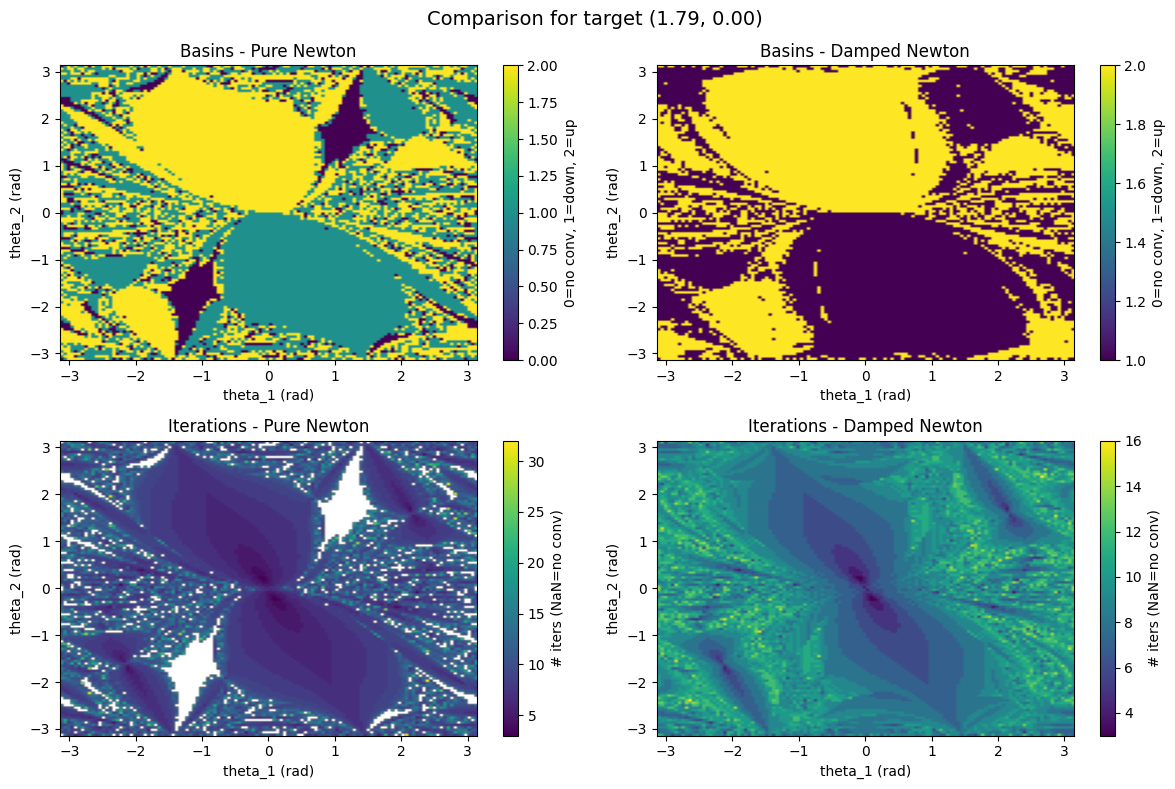

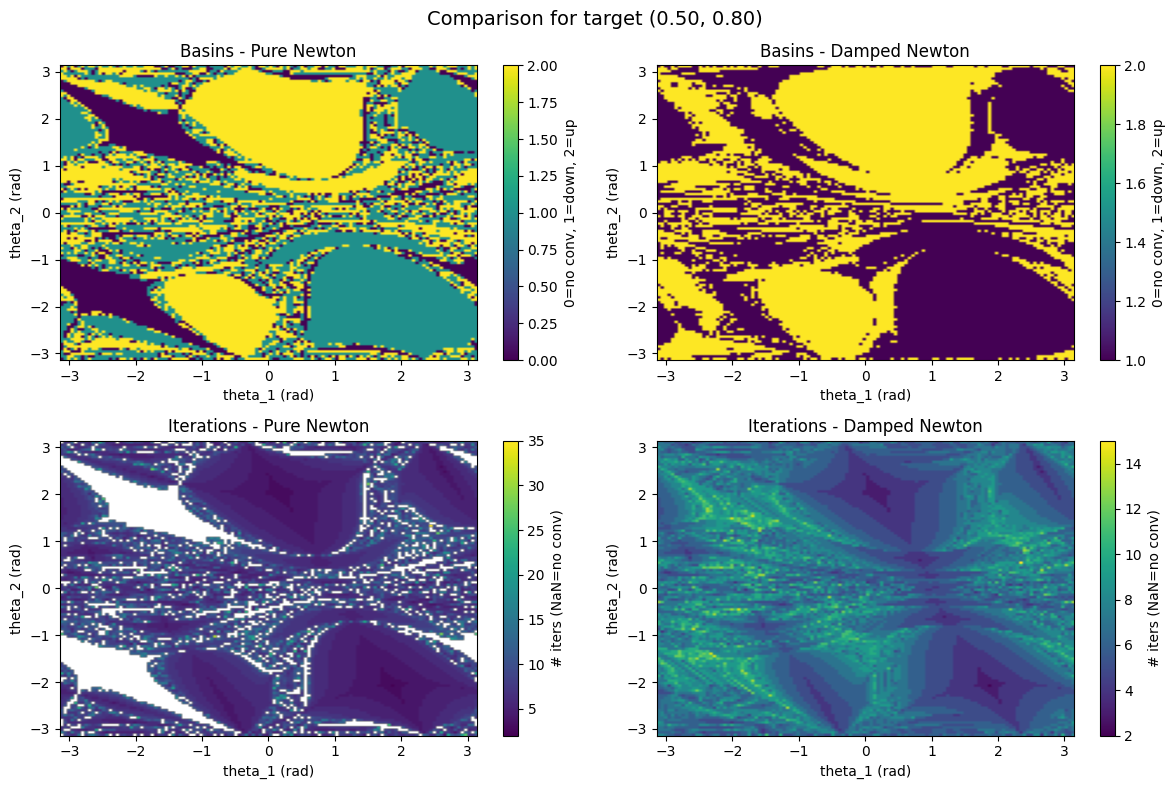

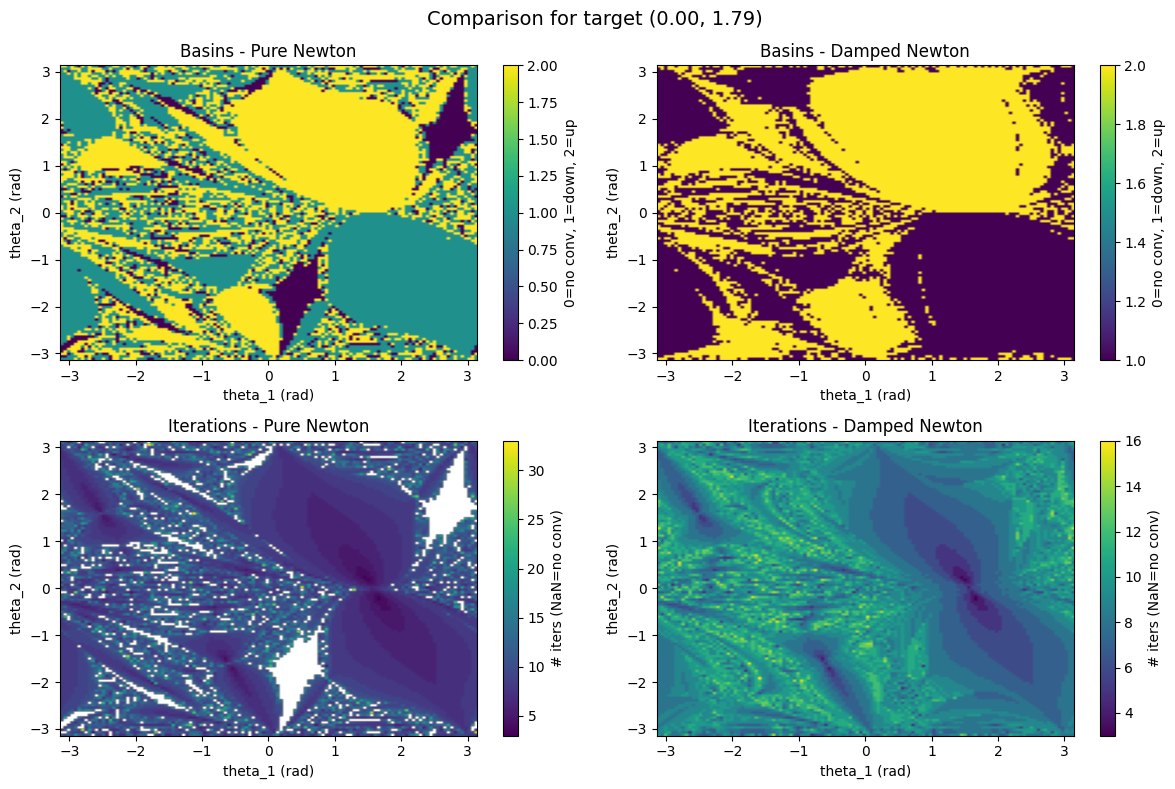

In [36]:
def run_grid_analysis(L1, L2, xd, yd, n=120, kmax=100, tol_f=1e-8, damping=False):
    # Construye una rejilla de valores iniciales de θ1 y θ2
    # en el intervalo [-π, π], con n divisiones en cada eje.
    th1 = np.linspace(-np.pi, np.pi, n)
    th2 = np.linspace(-np.pi, np.pi, n)

    # labels: matriz para clasificar cada punto inicial de la rejilla
    #   0 = no converge
    #   1 = converge a solución "codo abajo" (θ2 < 0)
    #   2 = converge a solución "codo arriba" (θ2 > 0)
    labels = np.zeros((n, n), dtype=int)

    # iters: matriz que guarda el número de iteraciones
    # necesarias para converger en cada punto inicial.
    iters  = np.full((n, n), np.nan)

    # Recorre todos los pares (θ1, θ2) de la rejilla como semillas iniciales
    for i, t1 in enumerate(th1):
        for j, t2 in enumerate(th2):
            # Ejecuta el método de Newton (puro o con damping)
            R = newton_ik(L1, L2, xd, yd, theta0=[t1, t2],
                          kmax=kmax, tol_f=tol_f, damping=damping, c1=1e-2)

            # Si converge y el residuo final es suficientemente pequeño:
            if R.converged and R.f_norm <= tol_f:
                # Clasifica según el signo de θ2 en la solución final
                labels[j, i] = 1 if R.theta[1] < 0 else 2
                # Guarda cuántas iteraciones tomó
                iters[j, i]  = R.iters
            else:
                # Si no converge, etiqueta = 0
                labels[j, i] = 0

    # Devuelve: mapa de etiquetas, mapa de iteraciones, y las rejillas θ1, θ2
    return labels, iters, th1, th2

def show_compare(xd, yd, n=120):
    # ------------------------------------------------------
    # Ejecuta el análisis en rejilla para Newton puro y con damping
    # ------------------------------------------------------
    lb_p, it_p, th1, th2 = run_grid_analysis(L1, L2, xd, yd, n=n, damping=False)
    lb_d, it_d, _,   _  = run_grid_analysis(L1, L2, xd, yd, n=n, damping=True)

    # Crea una figura con 4 subgráficas (2 filas x 2 columnas)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # ======================================================
    # FILA 1: Basins de atracción (clasificación de soluciones)
    # ======================================================

    # --- Basins con Newton puro ---
    im0 = axes[0,0].imshow(lb_p, origin='lower',
                           extent=[th1[0], th1[-1], th2[0], th2[-1]],
                           aspect='auto')
    axes[0,0].set_title("Basins - Pure Newton")
    axes[0,0].set_xlabel("theta_1 (rad)")
    axes[0,0].set_ylabel("theta_2 (rad)")
    # Barra de colores con etiqueta explicativa
    fig.colorbar(im0, ax=axes[0,0], label="0=no conv, 1=down, 2=up")

    # --- Basins con Newton con damping ---
    im1 = axes[0,1].imshow(lb_d, origin='lower',
                           extent=[th1[0], th1[-1], th2[0], th2[-1]],
                           aspect='auto')
    axes[0,1].set_title("Basins - Damped Newton")
    axes[0,1].set_xlabel("theta_1 (rad)")
    axes[0,1].set_ylabel("theta_2 (rad)")
    # Barra de colores con misma etiqueta
    fig.colorbar(im1, ax=axes[0,1], label="0=no conv, 1=down, 2=up")

    # ======================================================
    # FILA 2: Número de iteraciones necesarias
    # ======================================================

    # --- Iteraciones con Newton puro ---
    im2 = axes[1,0].imshow(it_p, origin='lower',
                           extent=[th1[0], th1[-1], th2[0], th2[-1]],
                           aspect='auto')
    axes[1,0].set_title("Iterations - Pure Newton")
    axes[1,0].set_xlabel("theta_1 (rad)")
    axes[1,0].set_ylabel("theta_2 (rad)")
    # Barra de colores indicando número de iteraciones
    fig.colorbar(im2, ax=axes[1,0], label="# iters (NaN=no conv)")

    # --- Iteraciones con Newton con damping ---
    im3 = axes[1,1].imshow(it_d, origin='lower',
                           extent=[th1[0], th1[-1], th2[0], th2[-1]],
                           aspect='auto')
    axes[1,1].set_title("Iterations - Damped Newton")
    axes[1,1].set_xlabel("theta_1 (rad)")
    axes[1,1].set_ylabel("theta_2 (rad)")
    # Barra de colores indicando número de iteraciones
    fig.colorbar(im3, ax=axes[1,1], label="# iters (NaN=no conv)")

    # ======================================================
    # Título general de la figura y ajuste del espaciado
    # ======================================================
    plt.suptitle(f"Comparison for target ({xd:.2f}, {yd:.2f})", fontsize=14)
    plt.tight_layout()
    plt.show()

# Ejemplo práctico:
# Target muy cercano al borde del workspace (≈ L1+L2)
show_compare(1.79, 0.00, n=120)
show_compare(0.5, 0.8, n=120)
show_compare(0, 1.79, n=120)
